# Q-Learning Test Case Prioritization - Data Fetching and Preprocessing
This notebook connects to Azure Cosmos DB, fetches test execution logs, and prepares data for Q-learning-based prioritization.

In [ ]:

import pandas as pd
from azure.cosmos import CosmosClient
from datetime import datetime
import numpy as np
import random
import matplotlib.pyplot as plt


# Cosmos DB Configuration
COSMOS_URI = "Your URI"
COSMOS_KEY = "Your key"
COSMOS_DB = "TestResultsDB"
COSMOS_CONTAINER = "Results"

# Initialize Cosmos DB client
client = CosmosClient(COSMOS_URI, credential=COSMOS_KEY)
database = client.get_database_client(COSMOS_DB)
container = database.get_container_client(COSMOS_CONTAINER)


In [21]:

# Query all test results
query = "SELECT * FROM c"
items = list(container.query_items(query=query, enable_cross_partition_query=True))

# Parse and preprocess required fields
data = []
for item in items:
    data.append({
        "testCase_id": item.get("testCase", {}).get("id"),
        "testcase_name": item.get("testCase", {}).get("name") or item.get("testCaseTitle"),
        "duration_sec": round(item.get("durationInMs", 0) / 1000.0, 2),
        "status": item.get("outcome"),
        "agent": item.get("computerName"),
        "build_id": item.get("build", {}).get("id"),
        "release_id": item.get("releaseReference", {}).get("id"),
        "run_id": item.get("testRunId"),
        "failure_type": item.get("failureType"),
        "start_time": item.get("startedDate"),
        "end_time": item.get("completedDate"),
        "upload_time": item.get("uploadTimestamp")
    })


In [22]:

# Load into DataFrame
df = pd.DataFrame(data)

# Preview data
print(" Execution Logs:")
df.head()


 Execution Logs:


,testCase_id,testcase_name,duration_sec,status,agent,build_id,release_id,run_id,failure_type,start_time,end_time,upload_time
0,17,RoboticPainter_FailsafeBlocksPainting {Autobot2},0.65,Passed,LAPTOP-ATOATJIH,34,77,144,None,2025-05-28T16:28:31.597Z,2025-05-28T16:28:32.243Z,2025-05-28T16:31:42.734460
1,18,HighPrecisionArm_BoundaryFailure {Autobot2},0.51,Passed,LAPTOP-ATOATJIH,34,77,144,None,2025-05-28T16:28:33.64Z,2025-05-28T16:28:34.147Z,2025-05-28T16:31:43.048369
2,19,ABBFlexiblePaintBot_LowEdgeCheck {Autobot2},1.79,Failed,LAPTOP-ATOATJIH,34,77,144,None,2025-05-28T16:28:34.147Z,2025-05-28T16:28:35.94Z,2025-05-28T16:31:43.080269
3,20,ABBPainterX_CycleStopWithError {Autobot2},60.00,Passed,LAPTOP-ATOATJIH,34,77,144,None,2025-05-28T16:28:35.943Z,2025-05-28T16:29:35.947Z,2025-05-28T16:31:43.095899
4,21,ABBIRB6000_MovementBoundaries {Autobot2},1.42,Passed,LAPTOP-ATOATJIH,34,77,144,None,2025-05-28T16:29:35.947Z,2025-05-28T16:29:37.37Z,2025-05-28T16:31:43.127066


In [23]:
# List of columns to drop
columns_to_drop = ['agent', 'run_id', 'failure_type', 'build_id', 'release_id']

# Drop the columns
df.drop(columns=columns_to_drop, inplace=True)
print("Remaining columns:")
print(df.columns.tolist())


Remaining columns:
['testCase_id', 'testcase_name', 'duration_sec', 'status', 'start_time', 'end_time', 'upload_time']


In [24]:
columns_to_check = ['testCase_id', 'testcase_name', 'duration_sec', 'status', 'start_time', 'end_time', 'upload_time']
# Show count of missing values in each column
missing_counts = df[columns_to_check].isnull().sum()
print("Missing values per column:")
print(missing_counts)


Missing values per column:
testCase_id       0
testcase_name     0
duration_sec      0
status           18
start_time        0
end_time          0
upload_time       0
dtype: int64


In [25]:
# Convert time columns to datetime and remove timezone
df['start_time'] = pd.to_datetime(df['start_time'], errors='coerce').dt.tz_localize(None)
df['end_time'] = pd.to_datetime(df['end_time'], errors='coerce').dt.tz_localize(None)
df['upload_time'] = pd.to_datetime(df['upload_time'], errors='coerce').dt.tz_localize(None)

#Sort and compute time since last run
df = df.sort_values(by=['testCase_id', 'upload_time'])
df['time_since_last_run'] = (
    df.groupby('testCase_id')['upload_time']
    .diff()
    .dt.total_seconds()
    .div(3600)
    .round(4)
)


In [26]:
df['time_since_last_run'] = df['time_since_last_run'].fillna(0)

In [27]:
# Sort by testCaseId and upload_time
df = df.sort_values(by=['testCase_id', 'upload_time'])

# Compute time since last run in hours
df['time_since_last_run'] = df.groupby('testCase_id')['upload_time'].diff()
df = df[df["time_since_last_run"].notna()]

In [28]:
# Failure flag and rate
df['failure'] = df['status'] == 'Failed'
df['failure_rate'] = df.groupby('testcase_name')['failure'].transform('mean')

# Encode test case names and status
df['testcase_encoded'] = df['testcase_name'].astype('category').cat.codes
df['status_encoded'] = df['status'].map({'Passed': 0, 'Failed': 1, 'Warning': 0.5}).fillna(0)

# Time since last run in minutes
df['time_since_last_run_minutes'] = df['time_since_last_run'].dt.total_seconds() / 60

# Normalize relevant features
df['normalized_time_last_run'] = (
    df['time_since_last_run_minutes'] - df['time_since_last_run_minutes'].min()
) / (df['time_since_last_run_minutes'].max() - df['time_since_last_run_minutes'].min())

df['normalized_duration'] = (
    df['duration_sec'] - df['duration_sec'].min()
) / (df['duration_sec'].max() - df['duration_sec'].min())

df['normalized_failure_rate'] = (
    df['failure_rate'] - df['failure_rate'].min()
) / (df['failure_rate'].max() - df['failure_rate'].min())

In [29]:
#Define State Using Continuous Values
df['state'] = df[['normalized_failure_rate', 'normalized_time_last_run', 'normalized_duration']].apply(tuple, axis=1)

#Map State to Index
unique_states = list(set(df['state']))
state_to_index = {state: i for i, state in enumerate(unique_states)}
df['state_index'] = df['state'].map(state_to_index)

#Define Dynamic Reward Function with Weighted Influence
def compute_reward(row, action):
    high_risk = row['normalized_failure_rate'] > 0.3
    short_duration = row['normalized_duration'] < 0.5
    recent_execution = row['normalized_time_last_run'] < 0.3

    # Assign weights to each condition
    risk_weight = 0.6 if high_risk else 0
    duration_weight = 0.4 if short_duration else 0
    execution_weight = 0.2 if recent_execution else 0

    total_weight = risk_weight + duration_weight + execution_weight

    if action == 1:
        return 1 if total_weight > 0 else -0.5
    return -1 if total_weight > 0 else 0.2

# Initialize Q-table (state x action)
Q_table = np.zeros((len(unique_states), 2))

#Q-learning Parameters
alpha = 0.3  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 1.0  # Exploration rate
episodes = 10000  # Number of training iterations
episode_rewards = []

#Training Loop
for episode in range(episodes):
    row = df.sample(1).iloc[0]  # Randomly select a test case
    s_idx = row['state_index']

    # Softmax Exploration
    if random.uniform(0, 1) < epsilon:
        probabilities = np.exp(Q_table[s_idx]) / np.sum(np.exp(Q_table[s_idx]))
        a_idx = np.random.choice([0, 1], p=probabilities)
    else:
        a_idx = np.argmax(Q_table[s_idx])

    # Compute Reward
    reward = compute_reward(row, a_idx)
    old_value = Q_table[s_idx, a_idx]
    next_max = np.max(Q_table[s_idx])

    # Q-learning Update
    Q_table[s_idx, a_idx] = old_value + alpha * (reward + gamma * next_max - old_value)

    # Store Episode Rewards
    episode_rewards.append(reward)

    # Epsilon Decay for Balanced Exploration
    epsilon = max(0.01, epsilon * 0.999)








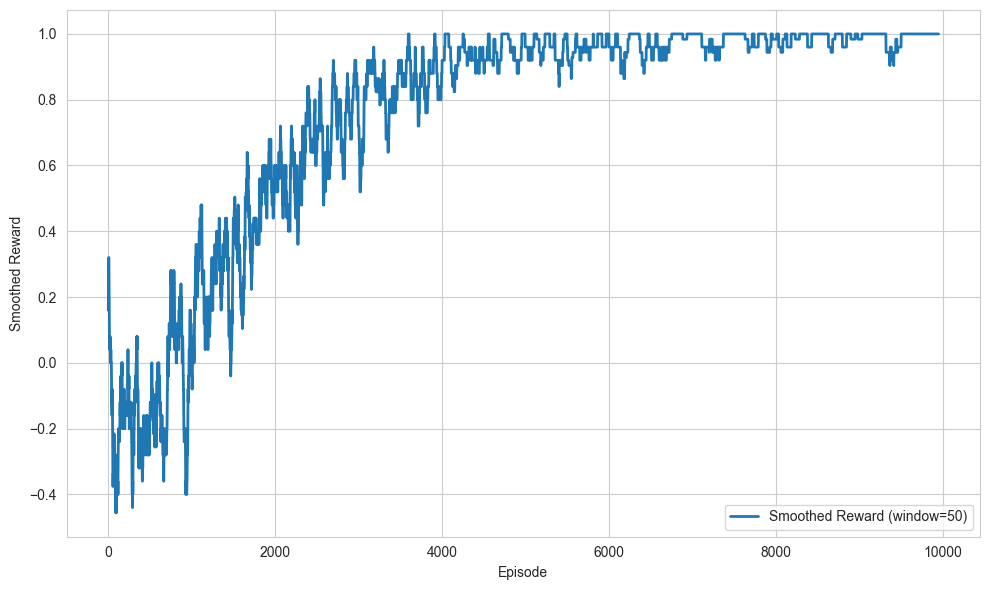

In [30]:
# Smoothed reward plot function
def moving_average(data, window=50):
    return np.convolve(data, np.ones(window) / window, mode='valid')
# Compute and plot
smoothed = moving_average(episode_rewards)
smoothed_x = np.arange(len(smoothed))

plt.figure(figsize=(10, 6))
plt.plot(smoothed_x, smoothed, label='Smoothed Reward (window=50)', linewidth=2)
plt.xlabel("Episode")
plt.ylabel("Smoothed Reward")
plt.legend(loc='lower right')  # 
plt.grid(True)
plt.tight_layout()
plt.show()


In [31]:
#Add Q-value and reward for 'run' action
df["Q_value"] = df["state_index"].apply(lambda idx: Q_table[idx, 1])

# Predict best action (0 = skip, 1 = run)
df["runDecision"] = df["state_index"].apply(lambda idx: np.argmax(Q_table[idx]))

#Filter test cases where best action is 'run'
selected_tests = df[df["runDecision"] == 1].copy()
selected_tests = selected_tests.sort_values(by="Q_value", ascending=False)
selected_tests = selected_tests.drop_duplicates(subset="testcase_name", keep="first")
selected_tests.reset_index(inplace=True)
selected_tests.to_csv("CosmosDB/scheduled_tests_qlearning.csv")

#Display results 
print("\n Q-Learning Selected Test Cases:")
print(selected_tests[[
    "testCase_id",
    "testcase_name",
    "Q_value",
    "duration_sec",
    "time_since_last_run"
]].head(32))

print("\n Saved to: CosmosDB/scheduled_tests_qlearning.csv")



 Q-Learning Selected Test Cases:
   testCase_id                                     testcase_name   Q_value  \
0           12          PaintBotFaultyMove_ShouldFail {Autobot1}  4.041740   
1           11            PaintBotEdgeTolerance_Check {Autobot1}  4.041740   
2           32                ABB5500_ResetAndOperate {Autobot3}  4.041740   
3           26       ABBPaintingBot_RecoveryFromCrash {Autobot2}  3.857463   
4           34        ABBPaintMaster_ResetClearsState {Autobot3}  3.857463   
5           16   ABBAdvancedPaintBot_FailsafeMovement {Autobot1}  3.667488   
6           10           PaintProSystem_ResetPosition {Autobot1}  3.667488   
7            7                  SprayRobot_ResetWorks {Autobot1}  3.667488   
8            5           PaintABB5400_MotionRangeCheck{Autobot1}  3.667488   
9           25              CompactPaintBot_QuickTest {Autobot2}  3.471637   
10          13         ABBXPaintControl_ResetAndRetry {Autobot1}  3.471637   
11          33         SmartPa

In [32]:
total_q_value = selected_tests["Q_value"].sum()
print(f"\n Total Q-Value (Priority Score) of Selected Tests: {total_q_value:.4f}")
total_duration = selected_tests["duration_sec"].sum()
print(f"\n Total Duration of Selected Test Cases: {total_duration:.2f} seconds")



 Total Q-Value (Priority Score) of Selected Tests: 108.6163

 Total Duration of Selected Test Cases: 467.63 seconds


In [ ]:
# Total number of test cases
total_tests = len(df)

# 0.4% of total test cases
top_k = int(total_tests * 0.004)
# Assign Q-value from action=1
df["Q_value"] = df["state_index"].apply(lambda idx: Q_table[idx, 1])

# Predict best action
df["runDecision"] = df["state_index"].apply(lambda idx: np.argmax(Q_table[idx]))
run_candidates = df[df["runDecision"] == 1].copy()

run_candidates = run_candidates.sort_values(by="Q_value", ascending=False)
run_candidates = run_candidates.drop_duplicates(subset="testcase_name", keep="first")
selected_tests = run_candidates.head(top_k)
selected_tests.reset_index(drop=True, inplace=True)
selected_tests.to_csv("CosmosDB/scheduled_tests_qlearning.csv", index=False)


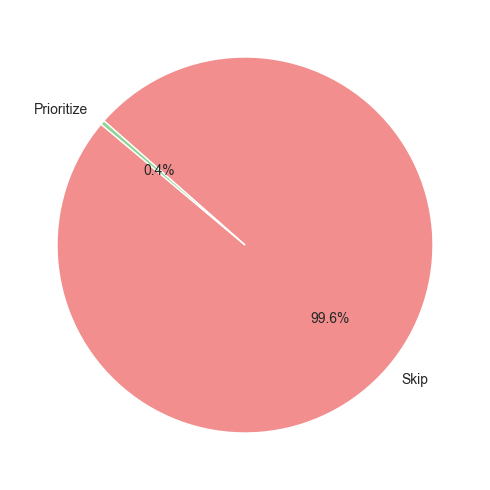

In [34]:
import matplotlib.pyplot as plt
run_counts = df['runDecision'].value_counts()
labels = ['Skip', 'Prioritize']
colors = ['#f28e8e', '#8fd694']
plt.figure(figsize=(5, 5))
plt.pie(run_counts, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
plt.tight_layout()
plt.show()


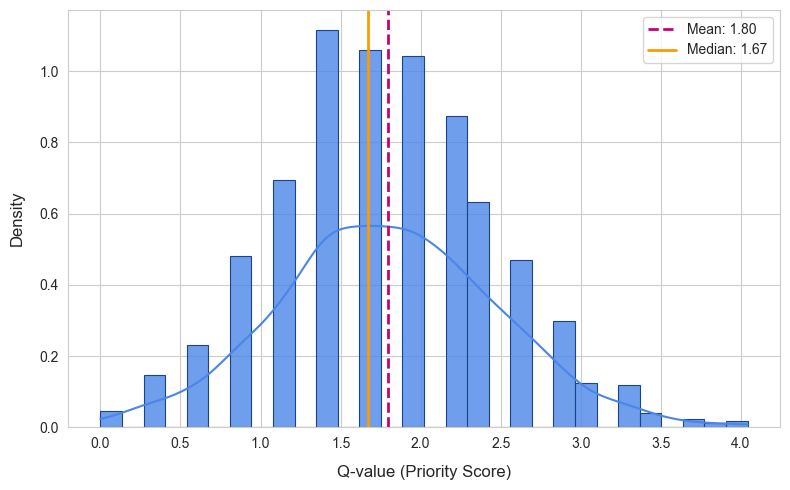

In [35]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

sns.set_style("whitegrid")
plt.figure(figsize=(8, 5), dpi=100)
ax = sns.histplot(
    data=df,
    x="Q_value",
    bins=30,
    kde=True, 
    color='#4a86e8',  
    edgecolor='#1c4587',  
    alpha=0.8,
    linewidth=0.8,
    stat='density'  
)

# Add mean and median lines
mean_val = df['Q_value'].mean()
median_val = df['Q_value'].median()
plt.axvline(mean_val, color='#c90076', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
plt.axvline(median_val, color='#ff9900', linestyle='-', linewidth=2, label=f'Median: {median_val:.2f}')

# Add distribution information
skewness = stats.skew(df['Q_value'])
kurtosis = stats.kurtosis(df['Q_value'])
props = dict(boxstyle='round', facecolor='white', alpha=0.8)

plt.xlabel('Q-value (Priority Score)', fontsize=12, labelpad=10)
plt.ylabel('Density', fontsize=12, labelpad=10)
plt.legend(fontsize=10)
plt.tight_layout()



plt.show()

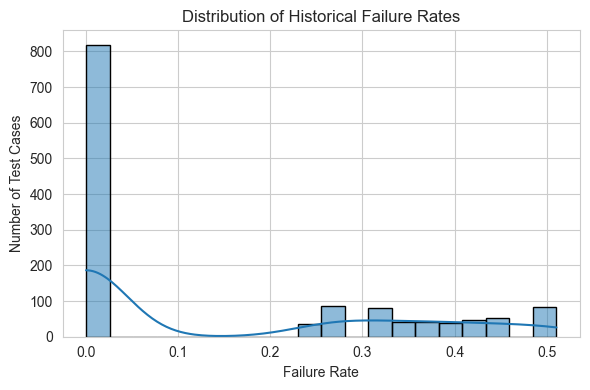

In [36]:
# Re-import packages and load user's actual 'df' if it was previously defined
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Simulate loading user's data from the last known structure (assuming df already exists in memory with correct columns)
# Plot 1: Histogram with KDE of failure_rate
plt.figure(figsize=(6, 4))
sns.histplot(df['failure_rate'], bins=20, kde=True, edgecolor='black')
plt.title('Distribution of Historical Failure Rates')
plt.xlabel('Failure Rate')
plt.ylabel('Number of Test Cases')
plt.tight_layout()



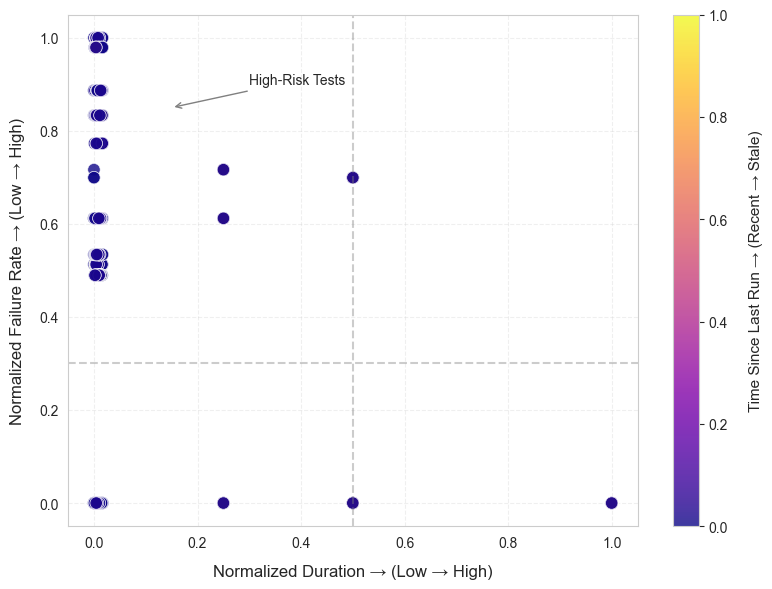

In [37]:
plt.figure(figsize=(8, 6))  
scatter = plt.scatter(
    df['normalized_duration'],
    df['normalized_failure_rate'],
    c=df['normalized_time_last_run'],
    cmap='plasma', 
    s=80,           
    alpha=0.8,      
    edgecolor='w',  
    linewidth=0.5
)

# Add annotations for key clusters/outliers
plt.annotate('High-Risk Tests', 
             xy=(0.15, 0.85), 
             xytext=(0.3, 0.9),
             arrowprops=dict(arrowstyle='->', color='gray'))

# Add reference elements
plt.axvline(x=0.5, color='gray', linestyle='--', alpha=0.4)  
plt.axhline(y=0.3, color='gray', linestyle='--', alpha=0.4)  

# Enhanced labels and titles
plt.xlabel('Normalized Duration → (Low → High)', fontsize=12, labelpad=10)
plt.ylabel('Normalized Failure Rate → (Low → High)', fontsize=12, labelpad=10)

    

# Colorbar customization
cbar = plt.colorbar(scatter)
cbar.set_label('Time Since Last Run → (Recent → Stale)', 
               fontsize=11, labelpad=15)
cbar.ax.tick_params(labelsize=10)

# Grid and styling
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()